In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import joblib
from google.cloud import storage

import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub
path = kagglehub.dataset_download("ealaxi/paysim1")
print("Path to dataset files:", path)

Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2


In [3]:
!ls /home/jupyter/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2

PS_20174392719_1491204439457_log.csv


In [4]:
!gsutil cp \
/home/jupyter/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2/PS_20174392719_1491204439457_log.csv \
gs://bucket2025nahumfg/inputs/lab_04

Copying file:///home/jupyter/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2/PS_20174392719_1491204439457_log.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][470.7 MiB/470.7 MiB]                                                
Operation completed over 1 objects/470.7 MiB.                                    


In [5]:
# Load dataset
df = pd.read_csv("gs://bucket2025nahumfg/inputs/lab_04/PS_20174392719_1491204439457_log.csv")
df = df.sample(frac=0.01, random_state=42)
df = df.reset_index(drop=True)
df.shape

(63626, 11)

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

type
CASH_OUT    22489
PAYMENT     21324
CASH_IN     14121
TRANSFER     5289
DEBIT         403
Name: count, dtype: int64


Text(0, 0.5, 'Amount')

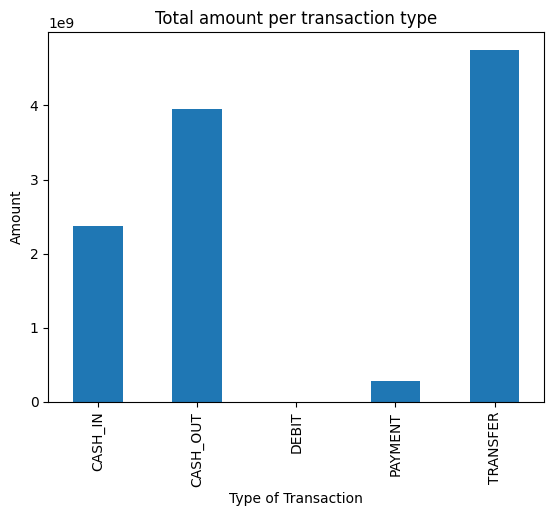

In [8]:
print(df.type.value_counts())
var = df.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount')

In [9]:
#working with imbalanced data
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts()

isFraud
0    63539
1       87
Name: count, dtype: int64

## Prepare data for Modeling

In [10]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
X = pd.concat([df.drop('type', axis=1), pd.get_dummies(df['type'])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,278,330218.42,20866.00,351084.42,452419.57,122201.15,0,True,False,False,False,False
1,15,11647.08,30370.00,18722.92,0.00,0.00,0,False,False,False,True,False
2,10,152264.21,106589.00,258853.21,201303.01,49038.80,0,True,False,False,False,False
3,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0,False,False,False,False,True
4,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,True,False,False,False,False


In [11]:
y = X[['isFraud']]
X = X.drop(['isFraud'],axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42, shuffle=False)
print (X_train.shape, X_test.shape)

(44538, 11) (19088, 11)


In [13]:
%%time
forest=RandomForestClassifier()
forest.fit(X_train,y_train)

CPU times: user 3.92 s, sys: 15.7 ms, total: 3.93 s
Wall time: 3.93 s


RandomForestClassifier()

In [14]:
y_prob=forest.predict_proba(X_test)
y_pred=forest.predict(X_test)

print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
print('F1 - score :',(f1_score(y_test,y_pred)))

print('Confusion_matrix : ')
print(confusion_matrix(y_test,y_pred))

print("classification_report")
print(classification_report(y_test,y_pred))

AUPRC : 0.7175642927256958
F1 - score : 0.7441860465116279
Confusion_matrix : 
[[19061     0]
 [   11    16]]
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19061
           1       1.00      0.59      0.74        27

    accuracy                           1.00     19088
   macro avg       1.00      0.80      0.87     19088
weighted avg       1.00      1.00      1.00     19088



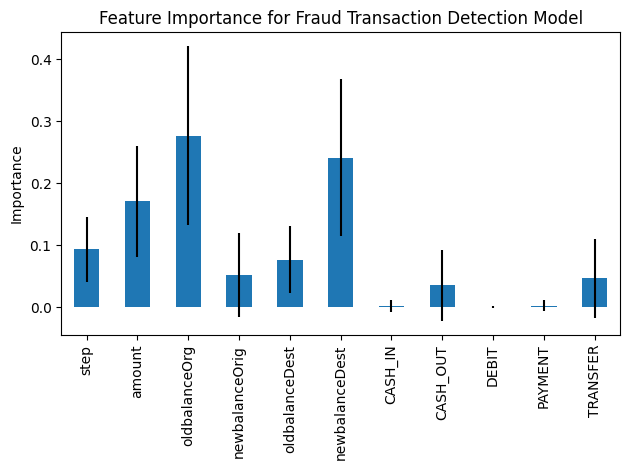

In [15]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()

In [16]:
BUCKET_NAME="bucket2025nahumfg"

In [17]:
FILE_NAME = "model.joblib"
joblib.dump(forest, FILE_NAME)

# Upload the saved model file to GCS

BLOB_PATH = "fraud_detection/model/"
BLOB_NAME = BLOB_PATH + FILE_NAME

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename("model.joblib")

In [20]:
REGION = "us-central1"
MODEL_DISPLAY_NAME = "fraud-detection-model"
ARTIFACT_GCS_PATH = f'gs://{BUCKET_NAME}/{BLOB_PATH}'


! gcloud beta ai models upload \
 --region=$REGION \
 --display-name=$MODEL_DISPLAY_NAME \
 --container-image-uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest" \
 --artifact-uri=$ARTIFACT_GCS_PATH


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [8716380525138280448]...done.                            


In [21]:
! gcloud beta ai models list \
 --region $REGION \
 --filter=display_name=$MODEL_DISPLAY_NAME


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
3893728015233843200  fraud-detection-model


In [22]:
MODEL_ID = "3893728015233843200"

## Modelo deployment

In [23]:
ENDPOINT_DISPLAY_NAME = "fraud-detection-model-ep1"

In [24]:
! gcloud beta ai endpoints create \
 --region=$REGION \
 --display-name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [3478694158506393600]...done.                            
Created Vertex AI endpoint: projects/330930586045/locations/us-central1/endpoints/3994333329175347200.


In [25]:
! gcloud beta ai endpoints list \
 --region=$REGION \
 --filter=display_name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
3994333329175347200  fraud-detection-model-ep1


In [28]:
ENDPOINT_ID = "3994333329175347200"

## Deploy the model 

In [29]:
DEPLOYED_MODEL_NAME = "fraud-detection-model-v1"
MACHINE_TYPE = "n1-standard-2"

In [ ]:
! gcloud beta ai endpoints deploy-model $ENDPOINT_ID\
 --region=$REGION \
 --model=$MODEL_ID \
 --display-name=$DEPLOYED_MODEL_NAME \
 --machine-type=$MACHINE_TYPE \
 --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2066815675325743104]...⠛                                

In [ ]:
DEPLOYED_MODEL_ID = "fraud-detection-model-ep1"

## Test endpoint

In [ ]:
ENDPOINT_ID="8408986863905275904"
PROJECT_ID="330930586045"
INPUT_DATA_FILE="INPUT-JSON"

In [ ]:
!curl \
-X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
"https://us-central1-aiplatform.googleapis.com/v1/projects/${PROJECT_ID}/locations/us-central1/endpoints/${ENDPOINT_ID}:predict" \
-d "@${INPUT_DATA_FILE}"

In [ ]:
#Test the model endpoint using Python SDK

#create list to hold request data
instances = [
                [1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.24, 0.2879, 0.81, 0.0, 3.0, 13.0],
            ]
prediction = endpoint.predict(instances=instances)
print(prediction)